In [55]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is alr

In [56]:
# load the dataset
tweets=pd.read_csv('/content/Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


## remove twitter account

In [57]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [58]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], "@[\w]*")
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


## remove link

In [59]:
cleaned_tweets = []

for index, row in tweets.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tidy_Tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['Tidy_Tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


## removing tweets with empty text

In [60]:
tweets = tweets[tweets['Tidy_Tweets']!='']
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


## dropping duplicate rows

In [61]:
tweets.drop_duplicates(subset=['Tidy_Tweets'], keep=False)
tweets = tweets.reset_index(drop=True)
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


## Removing Punctuations, Numbers and Special characters
* This step should not be followed if we also want to do sentiment analysis on __key phrases__ as well, because semantic meaning in a sentence needs to be present. So here we will create one additional column 'absolute_tidy_tweets' which will contain absolute tidy words which can be further used for sentiment analysis on __key words__.

In [62]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [63]:
tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: clean_text(x))
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


## remove emoji

In [64]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [65]:
tweets['Tidy_Tweets']=tweets['Tidy_Tweets'].apply(lambda x: remove_emoji(x))
tweets.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


# stopwords

In [ ]:
#importing given stopwords file
with open("/content/stop.txt") as stop_words:
    stop_words = stop_words.read()
    print(type(stop_words))
    print(stop_words)

In [94]:
#stopwords_set = set(stop_words)

#sw_list = ['im','\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
#lines.extend(sw_list)
#stopwords_set = set(lines)
cleaned_tweets = []

for index, row in tweets.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stop_words and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets
tweets.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulations tesla china amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,haha
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,tweets represent realworld allocation
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome


## Tokenized

In [95]:
tokenized_tweet = tweets['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head(10)

0                                         [im, alien]
1            [ray, tracing, cyberpunk, hdr, nextlevel]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulations, tesla, china, amazing, execu...
5                                    [happy, year, ox]
6                    [frodo, underdoge, thought, fail]
7                                               [haha]
8           [tweets, represent, realworld, allocation]
9                              [entertaining, outcome]
Name: absolute_tidy_tweets, dtype: object

## converting words to lemmas

In [96]:
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head(10)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0                                         [im, alien]
1            [ray, tracing, cyberpunk, hdr, nextlevel]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulation, tesla, china, amazing, execut...
5                                    [happy, year, ox]
6                    [frodo, underdoge, thought, fail]
7                                               [haha]
8            [tweet, represent, realworld, allocation]
9                              [entertaining, outcome]
Name: absolute_tidy_tweets, dtype: object

## joining all tokens into sentences

In [97]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets['absolute_tidy_tweets'] = tokenized_tweet
tweets.head(10)


,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution year
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,haha
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,tweet represent realworld allocation
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome


## <a id='8'>8. Fetch sentiments</a>
To proceed further, we need to know the sentiment type of every tweet, that can be done using two ways: <br/>
    __a. Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)<br/>__
    __b. Using TextBlob<br/>__

In [98]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

### <a id='8Aa'>a. Using NLTK's SentimentIntensityAnalyzer</a>

In [99]:
sentiments_using_SIA = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,absolute_tidy_tweets
pos,1749
neg,189


In [100]:
tweets.Tidy_Tweets[3]

'doge is underestimated'

In [101]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets.absolute_tidy_tweets[3])

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}

In [102]:
df=pd.DataFrame()
df['Tweets'] = tweets.absolute_tidy_tweets
df['scores'] = tweets['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Tweets,scores
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,ray tracing cyberpunk hdr nextlevel,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulation tesla china amazing execution year,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [103]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution year,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [104]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Tweets,scores,compound,sentiment
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,ray tracing cyberpunk hdr nextlevel,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulation tesla china amazing execution year,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive
...,...,...,...,...
1933,true sound surreal negative propaganda easy fi...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative
1934,make term condition clicking accept,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive
1935,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1936,dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative


In [105]:
tweets.describe()

,Tweets,Tidy_Tweets,absolute_tidy_tweets
count,1938,1938,1938
unique,1936,1661,1558
top,The most entertaining outcome is the most likely,,
freq,2,80,251


In [106]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp.style.background_gradient(cmap='rainbow')

,sentiment,Tweets
2,Positive,873
1,Neutral,836
0,Negative,229


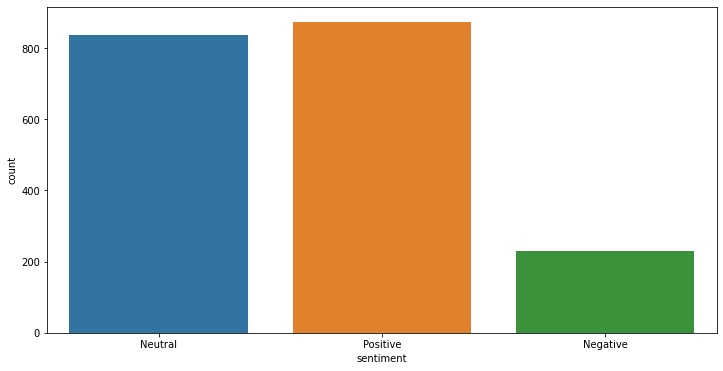

In [107]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

### <a id='8Ab'>b. Using TextBlob</a>

In [108]:
sentiments_using_textblob = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,absolute_tidy_tweets
pos,1767
neg,171


##### *NLTK* gives us more negative sentiments than TexBlob, so we will prefer NLTK, since classfication seems better.

In [109]:
tweets['sentiment'] = sentiments_using_SIA
tweets.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets,sentiment
0,@kunalb11 Im an alien,im an alien,im alien,pos
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel,pos
2,@joerogan @Spotify Great interview!,great interview,great interview,pos
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated,neg
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution year,pos


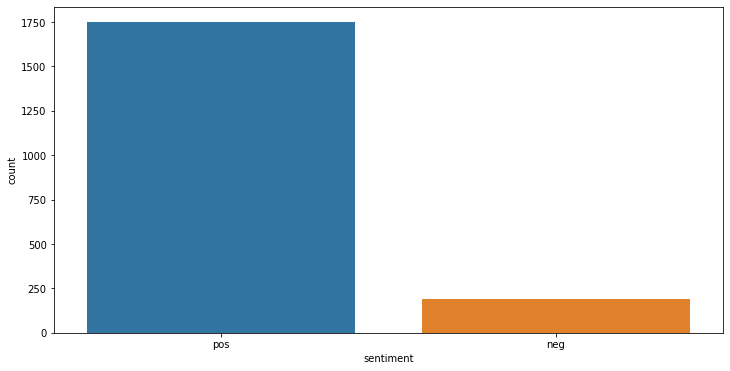

In [110]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=tweets)